In [194]:
import numpy as np
import scipy
from scipy import io
from time import time
import sys
import matplotlib.pyplot as plt

%matplotlib inline

CROSSVAL_K = 12
NUM_TRAINING_EXAMPLES = [100, 200, 500, 1000, 2000, 4741]

In [195]:
def print_now(s):
    print(s)
    sys.stdout.flush()

In [177]:
def shuffle_in_unison(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [178]:
def timer(func):
    def func_wrapper(*args, **kwargs):
        start_time = time()
        print("Start processing...")
        sys.stdout.flush()
        retval = func(*args, **kwargs)
        print("Done!")
        print("Time taken: {} seconds".format(time() - start_time))
        sys.stdout.flush()
        return retval
    return func_wrapper

In [285]:
data = io.loadmat("data/spam-dataset/spam_data.mat")
spam_data = data['training_data'].astype(np.float)
spam_labels = np.ravel(data['training_labels']).astype(np.float)
spam_data, spam_labels = shuffle_in_unison(spam_data, spam_labels)
spam_data /= np.linalg.norm(spam_data, axis=1).reshape((5172, 1))

training_data, validation_data = spam_data[:4741], spam_data[4741:]
training_labels, validation_labels = spam_labels[:4741], spam_labels[4741:]
test_data = data['test_data']
test_data /= np.linalg.norm(test_data, axis=1).reshape((5857, 1))
num_features = training_data.shape[1]

In [286]:
priors = np.array([np.sum(training_labels==i) \
                   / len(training_labels) for i in range(2)])
for i, x in enumerate(priors):
    print_now("Prior probability of class {} : {}".format(i, x))

Prior probability of class 0 : 0.7089221683189201
Prior probability of class 1 : 0.2910778316810799


In [287]:
def LDA(training_data, training_labels, prediction_data, gamma):
    global num_features
    classes_mean_MLE = \
        np.array([np.mean(training_data[training_labels == i], axis=0) \
                  for i in range(2)])
        
    cov_matrices = np.array([np.cov(training_data[training_labels == i].T) \
                             for i in range(2)])
    cov_mean = np.mean(cov_matrices, axis=0) + np.eye(num_features) * gamma
    cov_mean_inv = np.linalg.inv(cov_mean)
    
    LDF = np.array([ \
        classes_mean_MLE[i].dot(cov_mean_inv).dot(prediction_data.T) - \
        0.5 * classes_mean_MLE[i].dot(cov_mean_inv).dot(classes_mean_MLE[i].T) + \
        np.log(priors[i]) for i in range(2)
    ])
    predictions = np.argmax(LDF, axis=0)
    return predictions

In [288]:
@timer
def cross_validate(training_data, training_labels, gamma_value, \
                   cross_validation_indices, CROSSVAL_K, DA_func):
    print_now("Runing cross validation for γ value of: {}".format(gamma_value))
    cross_validation_data = \
        np.array(np.split(training_data[cross_validation_indices], CROSSVAL_K))
    cross_validation_labels = \
        np.array(np.split(training_labels[cross_validation_indices], CROSSVAL_K))
    cross_validation_accuracy = 0.0
    for i in range(CROSSVAL_K):
        mask = np.ones(CROSSVAL_K, dtype=bool)
        mask[i] = 0
        test_set = np.concatenate(cross_validation_data[mask])
        test_labels = np.concatenate(cross_validation_labels[mask])
        validation_set = cross_validation_data[i]
        validation_labels = cross_validation_labels[i]
        validation_prediction = \
            DA_func(test_set, test_labels, validation_set, gamma_value)
        cross_validation_accuracy += \
            np.sum(validation_labels == validation_prediction) \
            / float(len(validation_labels))
    cross_validation_accuracy /= CROSSVAL_K
    return cross_validation_accuracy

In [289]:
@timer
def crossval(training_data, training_labels, DA_func, gamma_values):
    max_accuracy, best_gamma_value = 0.0, 0.0
    cross_validation_indices = np.arange(0, training_data.shape[0])
    np.random.shuffle(cross_validation_indices)
    
    for gamma_value in gamma_values:
        cross_validation_accuracy = \
            cross_validate(training_data, training_labels, \
                gamma_value, cross_validation_indices, CROSSVAL_K, DA_func)
        print_now("Cross validation accuracy for C value {}: {}".format( \
              gamma_value, cross_validation_accuracy))
        if cross_validation_accuracy > max_accuracy:
            max_accuracy, best_gamma_value = cross_validation_accuracy, gamma_value
    print_now("Best gamma value found to be: {}".format(best_gamma_value))
    return best_gamma_value

In [290]:
best_LDA_gamma_value = crossval(spam_data, spam_labels, LDA, np.array([10**i for i in range(-15, 0)]))

Start processing...
Start processing...
Runing cross validation for γ value of: 1e-15
Done!
Time taken: 0.9742472171783447 seconds
Cross validation accuracy for C value 1e-15: 0.9234338747099767
Start processing...
Runing cross validation for γ value of: 1e-14
Done!
Time taken: 1.007411003112793 seconds
Cross validation accuracy for C value 1e-14: 0.9234338747099767
Start processing...
Runing cross validation for γ value of: 1e-13
Done!
Time taken: 0.848578929901123 seconds
Cross validation accuracy for C value 1e-13: 0.9234338747099767
Start processing...
Runing cross validation for γ value of: 1e-12
Done!
Time taken: 1.0442979335784912 seconds
Cross validation accuracy for C value 1e-12: 0.9234338747099767
Start processing...
Runing cross validation for γ value of: 1e-11
Done!
Time taken: 0.8911759853363037 seconds
Cross validation accuracy for C value 1e-11: 0.9234338747099767
Start processing...
Runing cross validation for γ value of: 1e-10
Done!
Time taken: 0.9644031524658203 seco

In [298]:
@timer
def run_LDA():
    global best_LDA_gamma_value
    validation_errors = []
    for num_data_points in NUM_TRAINING_EXAMPLES:
        print_now("Training on {} data points...".format(num_data_points))
        data, labels = \
            training_data[:num_data_points], \
            training_labels[:num_data_points]
        predictions = \
            LDA(data, labels, validation_data, best_LDA_gamma_value)
        
        error_rate = np.sum(predictions != validation_labels) \
                     / float(len(validation_labels))
        print_now("Error rate with {} training data: {}"\
                  .format(num_data_points, error_rate))
        validation_errors.append(error_rate)

    plt.title("LDA on validation data")
    plt.xlabel("Number of training examples")
    plt.ylabel("Error rate")
    plt.plot(NUM_TRAINING_EXAMPLES, validation_errors)

Start processing...
Training on 100 data points...
Error rate with 100 training data: 0.26450116009280744
Training on 200 data points...
Error rate with 200 training data: 0.15777262180974477
Training on 500 data points...
Error rate with 500 training data: 0.10904872389791183
Training on 1000 data points...
Error rate with 1000 training data: 0.09976798143851508
Training on 2000 data points...
Error rate with 2000 training data: 0.08816705336426914
Training on 4741 data points...
Error rate with 4741 training data: 0.09048723897911833
Done!
Time taken: 0.24148297309875488 seconds


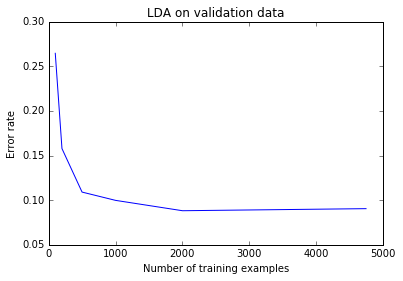

In [299]:
run_LDA()

In [300]:
def QDA(training_data, training_labels, prediction_data, gamma):
    N = prediction_data.shape[0]
    classes_mean_MLE = \
        np.array([np.mean(training_data[training_labels == i], axis=0) \
                  for i in range(2)])
        
    cov_matrices = \
        np.array([np.cov(training_data[training_labels == i].T) + \
                  np.eye(num_features) * gamma for i in range(2)])
    cov_matrices_inv = np.array([np.linalg.inv(mat) for mat in cov_matrices])
    
    classes_mean_reshaped = \
        np.array([np.tile(mean.reshape((num_features, 1)), N).T \
                  for mean in classes_mean_MLE])

    QDF = np.array([ \
            -0.5 * (prediction_data - classes_mean_reshaped[i]) \
                    .dot(cov_matrices_inv[i])\
                    .dot((prediction_data - classes_mean_reshaped[i]).T)\
                    .diagonal() \
            -0.5 * np.tile(np.log(np.linalg.norm(cov_matrices_inv[i])), N) \
            + np.tile(np.log(priors[i]), N) for i in range(2) \
    ])
    
    predictions = np.argmax(QDF, axis=0)
    return predictions

In [301]:
# Compute best QDA gamma value by cross validation
best_QDA_gamma_value = crossval(spam_data, spam_labels, QDA, np.array([10**i for i in range(-15, 0)]))

Start processing...
Start processing...
Runing cross validation for γ value of: 1e-15
Done!
Time taken: 1.4921329021453857 seconds
Cross validation accuracy for C value 1e-15: 0.9601701469450888
Start processing...
Runing cross validation for γ value of: 1e-14
Done!
Time taken: 1.5796000957489014 seconds
Cross validation accuracy for C value 1e-14: 0.9601701469450888
Start processing...
Runing cross validation for γ value of: 1e-13
Done!
Time taken: 1.461237907409668 seconds
Cross validation accuracy for C value 1e-13: 0.9601701469450888
Start processing...
Runing cross validation for γ value of: 1e-12
Done!
Time taken: 1.608764886856079 seconds
Cross validation accuracy for C value 1e-12: 0.9601701469450888
Start processing...
Runing cross validation for γ value of: 1e-11
Done!
Time taken: 1.4746878147125244 seconds
Cross validation accuracy for C value 1e-11: 0.9603634957463263
Start processing...
Runing cross validation for γ value of: 1e-10
Done!
Time taken: 1.390516996383667 secon

In [302]:
@timer
def run_QDA():
    global best_QDA_gamma_value
    validation_errors = []
    for num_data_points in NUM_TRAINING_EXAMPLES:
        print_now("Training on {} data points...".format(num_data_points))
        data, labels = \
            training_data[:num_data_points], \
            training_labels[:num_data_points]
        predictions = \
            QDA(data, labels, validation_data, best_QDA_gamma_value)
        
        error_rate = np.sum(predictions != validation_labels) \
                     / float(len(validation_labels))
        print_now("Error rate with {} training data: {}"\
                  .format(num_data_points, error_rate))
        validation_errors.append(error_rate)

    plt.title("QDA on validation data")
    plt.xlabel("Number of training examples")
    plt.ylabel("Error rate")
    plt.plot(NUM_TRAINING_EXAMPLES, validation_errors)

Start processing...
Training on 100 data points...
Error rate with 100 training data: 0.19953596287703015
Training on 200 data points...
Error rate with 200 training data: 0.13225058004640372
Training on 500 data points...
Error rate with 500 training data: 0.09048723897911833
Training on 1000 data points...
Error rate with 1000 training data: 0.048723897911832945
Training on 2000 data points...
Error rate with 2000 training data: 0.048723897911832945
Training on 4741 data points...
Error rate with 4741 training data: 0.04408352668213457
Done!
Time taken: 0.4975590705871582 seconds


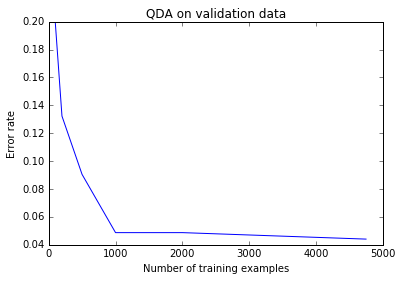

In [303]:
run_QDA()

In [297]:
@timer
def kaggle_dataset():
    predictions = QDA(spam_data, spam_labels, test_data, best_QDA_gamma_value)
    with open("kaggle_spam.txt", "w+") as kaggle_file:
        kaggle_file.write("Id,Category\n")
        for i in range(len(predictions)):
            kaggle_file.write(str(i+1)+","+str(predictions[i])+"\n")
        kaggle_file.close()
kaggle_dataset()

Start processing...
Done!
Time taken: 1.7051100730895996 seconds


### Part E
I used the same featurize.py that I used in HW1. My submission received a Kaggle score of 0.87620.
I added a total of 400 features which are the top 200 words in both spam and ham emails, which don't exist in the other dataset. Also, I removed these words: "other", "business", "path", "pleased", "record" and the '[' character.